In [1]:
#
# Initialization
#

import os
import sys

import ipynbname
from pathlib import Path

# Set notebook's src module path. Note that you may have to update your IDE's project settings to do the same for the
#  local library imports to work the same
MODULE_PATH = ipynbname.path().parent.parent
sys.path.append(str(MODULE_PATH))

# Keep paths consistent throughout notebook
os.chdir(MODULE_PATH)

# This should always be `./src`
print(f"Current working directory [{os.getcwd()}]")

# Place all local artifacts in a disposable, git-ignored directory
local_artifact_dir = Path(os.getcwd()).parent / "out"
local_artifact_dir.mkdir(parents=True, exist_ok=True)

# Autoreload imports at the beginning of cell execution.
#  https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

Current working directory [/Users/jbeckman/projects/capia/src]


In [2]:
#
# Setup utils
#

import subprocess

from utils.logger_util import LoggerUtil
from utils.utils import Utils
from utils import config

LOGGER = LoggerUtil(config.MODEL_ID, local_artifact_dir / "logs")
UTILS = Utils(LOGGER)

UTILS.describe_env()

# AWS instance specs can be found here https://aws.amazon.com/sagemaker/pricing/
AWS_INSTANCE = 'ml.m5.large' # 2 vCPU, 0 GPU, 8 GB memory, $0.134/hour
AWS_INSTANCE_2 = 'ml.m5.4xlarge' # 16 vCPU, 0 GPU, 64 GB memory, $0.922/hour
AWS_GPU_INSTANCE = 'ml.g4dn.xlarge' # 4 vCPU, 1 GPU, 16 GB memory, $0.736/hour
AWS_GPU_INSTANCE_2 = 'ml.g4dn.2xlarge' # 8 vCPU, 1 GPU, 32 GB memory, $1.053/hour
AWS_GPU_INSTANCE_3 = 'ml.g4dn.4xlarge' # 16 vCPU, 1 GPU, 64 GB memory, $1.505/hour
AWS_GPU_INSTANCE_4 = 'ml.g4dn.8xlarge' # 32 vCPU, 1 GPU, 128 GB memory, $2.72/hour
AWS_GPU_INSTANCE_5 = 'ml.g4dn.16xlarge' # 64 vCPU, 1 GPU, 256 GB memory, $5.44/hour
LOCAL_INSTANCE = 'local'
try:
    if subprocess.call('nvidia-smi') == 0:
        LOCAL_INSTANCE = 'local_gpu'
except:
    LOGGER.log("The nvidia-smi binary was not found and thus GPU computation is not supported. Using the default CPU "
               "computation")

# Change this to your desired instance type
INSTANCE_TYPE = LOCAL_INSTANCE
IS_LOCAL = LOCAL_INSTANCE == INSTANCE_TYPE

# Does the model use filedataset or CSVs
FILEDATASET_BASED = True

# Is the model univariate
ONE_DIM_TARGET = True

/Users/jbeckman/projects/capia/venv/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


2021-12-02 08:15:40.421916 Background logger started
2021-12-02 08:15:40.422527 The model id is [giia-1.0.3]
2021-12-02 08:15:40.422750 The MXNet version is [1.8.0]
2021-12-02 08:15:40.422882 The GluonTS version is [0.8.1]
2021-12-02 08:15:40.423000 The GPU count is [0]
2021-12-02 08:15:40.428655 The nvidia-smi binary was not found and thus GPU computation is not supported. Using the default CPU computation


In [3]:
#
# Parse dataset
#

from data_processing.parse import Parse

PARSE = Parse(LOGGER)

dataset_dir_path = local_artifact_dir / "datasets"

# Creates train and test dataset
PARSE.create_train_test_dataset(
    dataset_dir_path,
    filedataset_based=FILEDATASET_BASED,
    one_dim_target=ONE_DIM_TARGET,
    starting_date_truncate="2020-06-17 00:00:00"
    # starting_date_truncate="2021-03-01 00:00:00"
)

2021-12-02 08:15:52.198945 First sample:
2021-12-02 08:15:52.203877 
              open   high     low   close     volume
date                                                
2020-06-17  235.31  235.6  235.31  235.54  700.17587
2021-12-02 08:15:52.204264 Last sample:
2021-12-02 08:15:52.206829 
                        open     high      low    close    volume
date                                                             
2021-06-23 17:10:00  1982.95  1986.92  1981.31  1985.06  612.5914
2021-12-02 08:15:52.207129 Number of rows: 535271
2021-12-02 08:15:52.207232 Number of raw columns: 5
2021-12-02 08:15:52.220876 Train dataset starts at: 2020-06-17 00:00:00
2021-12-02 08:15:52.221507 Test dataset starts at: 2021-03-04 04:49:00
2021-12-02 08:15:52.221756 Building a univariate FileDataset
2021-12-02 08:15:52.316441 Parsed train and test datasets can be found in [/Users/jbeckman/projects/capia/out/datasets]


In [4]:
#
# Setup local/aws environment. If aws, upload the datasets to S3
#

from data_processing.aws_handler import AWSHandler
from sagemaker import LocalSession

AWS_HANDLER = AWSHandler(LOGGER, config.MODEL_ID)

sagemaker_session = None

model_output_dir_path = local_artifact_dir / config.MODEL_ID / "models"
model_output_dir_path.mkdir(parents=True, exist_ok=True)

if IS_LOCAL:
    LOGGER.log("Notebook is set to local mode, not uploading to S3")

    dataset_dir_uri = f"file://{dataset_dir_path}"
    model_output_dir_uri = f"file://{model_output_dir_path}"

    sagemaker_session = LocalSession()
    sagemaker_session.config = {
        'local': {
            'local_code': True,
            'container_root': str(model_output_dir_path)
        }
    }
else:
    sagemaker_session = AWS_HANDLER.sagemaker_session

    AWS_HANDLER.upload_train_datasets(dataset_dir_path, filedataset_based=FILEDATASET_BASED)
    dataset_dir_uri = AWS_HANDLER.s3_dataset_dir_uri

    model_output_dir_uri = AWS_HANDLER.s3_model_output_uri

LOGGER.log(f"Model output dir is [{model_output_dir_uri}]")

2021-12-02 08:15:59.326624 Notebook is set to local mode, not uploading to S3
2021-12-02 08:15:59.341256 Model output dir is [file:///Users/jbeckman/projects/capia/out/giia-1.0.3/models]


In [10]:
#
# Configure sagemaker and estimator
#

from ml.train_sff import Train

TRAIN = Train(LOGGER)

if IS_LOCAL:
    train_kwargs = {}
else:
    train_kwargs = {
        # 'checkpoint_s3_uri': model_output_dir_uri,
        'output_path': model_output_dir_uri,
        'code_location': model_output_dir_uri,
        'use_spot_instances': True,
        'max_wait': 18 * 60 * 60, # 18 hours
        'max_run': 18 * 60 * 60, # 18 hours
    }

estimator = TRAIN.create_model(config.SM_ROLE, INSTANCE_TYPE, sagemaker_session, train_kwargs)
TRAIN.fit_model(estimator, dataset_dir_uri)

Creating 04eb928bvw-algo-1-7inko ... 
Creating 04eb928bvw-algo-1-7inko ... done
Attaching to 04eb928bvw-algo-1-7inko
04eb928bvw-algo-1-7inko | 2021-12-02 13:22:44,182 sagemaker-training-toolkit INFO     Imported framework sagemaker_mxnet_container.training
04eb928bvw-algo-1-7inko | 2021-12-02 13:22:44,185 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
04eb928bvw-algo-1-7inko | 2021-12-02 13:22:44,200 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1-7inko"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{"batch_size":16,"context_length":60,"distr_output":"StudentTOutput","epochs":1,"learning_rate":0.001,"n_hidden_layer":2,"n_neurons_per_layer":10,"num_batches_per_epoch":10,"prediction_length":5}', 'SM_USER_ENTRY_POINT': 'sff.py', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_RESOURCE_CONFIG': '{"current_host":"algo-1-7inko","hosts":["algo-1-7inko"]}', 'SM_INPUT_DATA_CONFIG': '{"dataset":{"TrainingInputMode":"File"}}

In [17]:
#
# Load model
#

import pandas as pd
import matplotlib.pyplot as plt
from itertools import islice
from gluonts.model.predictor import Predictor

# Uncomment if you want to quickly compare AWS model with local model
# IS_LOCAL = False

if IS_LOCAL:
    # model_output_dir_path is basically the same path as it was before, though sagemaker appends a random temp
    # directory to the path. The path from TRAIN includes that random temp directory
    # model_dir_path = TRAIN.model_data_path.parent.parent / "model"
    model_dir_path = local_artifact_dir / "local_cli" / "model"
else:
    model_dir_path = AWS_HANDLER.download_model_from_s3(str(TRAIN.model_data_path), local_artifact_dir)

LOGGER.log(f"Model dir is [{model_dir_path}]")
predictor = Predictor.deserialize(model_dir_path)
LOGGER.log(f"Predictor metadata [{predictor.__dict__}]")

def plot_prob_forecasts(ts_list, forecast_list, plot_length=100):
    for target, forecast in islice(zip(ts_list, forecast_list), len(forecast_list)):
        prediction_intervals = (50.0, 90.0)
        legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
        ax = target[-plot_length:].plot(figsize=(10, 7), linewidth=2)
        forecast.plot(prediction_intervals=prediction_intervals, color='g')
        plt.grid(which="both")
        plt.legend(legend, loc="upper left")
        plt.show()
    
def plot_prob_forecasts_multi(ts_list, forecast_list, close_index, plot_length=60):
    for target, forecast in islice(zip(ts_list, forecast_list), len(forecast_list)):
        prediction_intervals = (50.0, 90.0)
        legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
        fig, ax = plt.subplots(1, 1, figsize=(10, 7))
        target[close_index][-plot_length:].plot(ax=ax)  # plot the time series
        forecast.copy_dim(close_index).plot(prediction_intervals=prediction_intervals, color='g')
        plt.grid(which="both")
        plt.legend(legend, loc="upper left")
        plt.show()

2021-12-02 08:44:31.461800 Model dir is [/Users/jbeckman/projects/capia/out/local_cli/model]
2021-12-02 08:44:31.482083 Predictor metadata [{'prediction_length': 5, 'freq': '1min', 'lead_time': 0, 'input_names': ['past_target'], 'prediction_net': gluonts.model.simple_feedforward._network.SimpleFeedForwardSamplingNetwork(batch_normalization=False, context_length=5, distr_output=gluonts.mx.distribution.student_t.StudentTOutput(), mean_scaling=True, num_hidden_dimensions=[560, 560, 560, 560, 560, 560, 560, 560, 560, 560], num_parallel_samples=100, prediction_length=5), 'batch_size': 32, 'input_transform': gluonts.transform._base.Chain(trans=[gluonts.transform.feature.AddObservedValuesIndicator(dtype=numpy.float32, imputation_method=gluonts.transform.feature.DummyValueImputation(dummy_value=0.0), output_field="observed_values", target_field="target"), gluonts.transform.split.InstanceSplitter(dummy_value=0.0, forecast_start_field="forecast_start", future_length=5, instance_sampler=gluonts.t

In [18]:
#
# Define test data and make a prediction
#

from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.dataset.common import load_datasets
from gluonts.dataset.stat import calculate_dataset_statistics
from utils.splitter import DateSplitter

import data_processing.gluonts_helper as gh

test_dates = ["2021-05-27 12:50:00", "2021-05-27 15:55:00", "2021-05-28 16:00:00", "2021-05-28 17:00:00"]
# test_dates = ["2021-05-22 17:00:00"]
test_datasets = []
feature_columns = []

if FILEDATASET_BASED:
    datasets = load_datasets(
        metadata=(dataset_dir_path / config.METADATA_DATASET_FILENAME).parent,
        train=(dataset_dir_path / config.TRAIN_DATASET_FILENAME).parent,
        test=(dataset_dir_path / config.TEST_DATASET_FILENAME).parent,
        one_dim_target=ONE_DIM_TARGET,
        cache=True
    )

    feature_columns_map = {}
    for feat in datasets.metadata.feat_static_cat:
        if feat.name.startswith("feature_column_"):
            feature_index = int(feat.name.split("_")[2])
            feature_columns_map[feature_index] = feat.cardinality
    feature_columns = [feature_columns_map.get(ele, 0) for ele in range(len(feature_columns_map))]

    for idx, date in enumerate(test_dates):
        # 1) Get splice of dataset for different dates with ample history\n",
        splitter = DateSplitter(
            prediction_length=-config.HYPER_PARAMETERS["prediction_length"],
            split_date=date,
            max_history=config.FREQTRADE_MAX_CONTEXT,
            # max_history=config.HYPER_PARAMETERS["context_length"] + config.HYPER_PARAMETERS["prediction_length"],
        )
        (_, train_dataset), (_, test_dataset) = splitter.split(datasets.test)

        LOGGER.log(f"Test dataset [{idx}] stats: {calculate_dataset_statistics(test_dataset)}")
        test_datasets.append(test_dataset)
else:
    test_dataset_filename = dataset_dir_path / config.TEST_CSV_FILENAME
    test_df = pd.read_csv(filepath_or_buffer=test_dataset_filename, header=0, index_col=0)

    feature_columns = gh.get_feature_columns(test_df, exclude_close=False)

    for idx, date in enumerate(test_dates):
        split_df = test_df[:date].tail(config.FREQTRADE_MAX_CONTEXT)
        test_dataset = gh.df_to_multivariate_target_dataset(split_df, feature_columns)

        LOGGER.log(f"Test dataset [{idx}] stats: {calculate_dataset_statistics(test_dataset)}")
        test_datasets.append(test_dataset)

print(f"feature_columns are [{feature_columns}]")

100%|██████████| 1/1 [00:00<00:00, 4219.62it/s]

2021-12-02 08:44:36.690856 Test dataset [0] stats: DatasetStatistics(integer_dataset=False, max_target=2839.360107421875, mean_abs_target=2756.0936873747496, mean_target=2756.0936873747496, mean_target_length=499.0, max_target_length=499, min_target=2652.25, feat_static_real=[], feat_static_cat=[], num_past_feat_dynamic_real=0, num_feat_dynamic_real=0, num_feat_dynamic_cat=0, num_missing_values=0, num_time_observations=499, num_time_series=1, scale_histogram=gluonts.dataset.stat.ScaleHistogram(base=2.0, bin_counts={11: 1}, empty_target_count=0))
2021-12-02 08:44:36.699299 Test dataset [1] stats: DatasetStatistics(integer_dataset=False, max_target=2866.31005859375, mean_abs_target=2800.4003006012026, mean_target=2800.4003006012026, mean_target_length=499.0, max_target_length=499, min_target=2687.14990234375, feat_static_real=[], feat_static_cat=[], num_past_feat_dynamic_real=0, num_feat_dynamic_real=0, num_feat_dynamic_cat=0, num_missing_values=0, num_time_observations=499, num_time_ser

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]


2021-12-02 08:44:42.793920 Aggregated performance
2021-12-02 08:44:42.794734 {
    "MSE": 208.04267578125,
    "abs_error": 60.719482421875,
    "abs_target_sum": 13934.7998046875,
    "abs_target_mean": 2786.9599609375,
    "seasonal_error": 3.909839808094574,
    "MASE": 3.1059831298544225,
    "MAPE": 0.004355781897902489,
    "sMAPE": 0.004366520419716835,
    "MSIS": 20.59087717182827,
    "QuantileLoss[0.1]": 33.531982421875,
    "Coverage[0.1]": 0.0,
    "RMSE": 14.423684542489482,
    "NRMSE": 0.005175418644205254,
    "ND": 0.0043573989775906,
    "wQuantileLoss[0.1]": 0.002406348343131219,
    "mean_absolute_QuantileLoss": 33.531982421875,
    "mean_wQuantileLoss": 0.002406348343131219,
    "MAE_Coverage": 0.1,
    "OWA": NaN
}


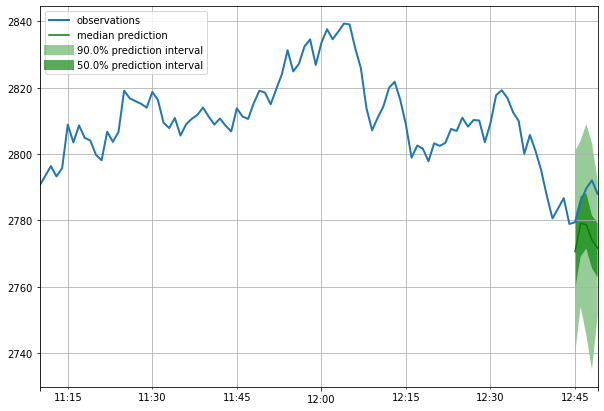

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  9.82it/s]


2021-12-02 08:44:43.774148 Aggregated performance
2021-12-02 08:44:43.774688 {
    "MSE": 41.05329895019531,
    "abs_error": 34.57861328125,
    "abs_target_sum": 14049.939453125,
    "abs_target_mean": 2809.987890625,
    "seasonal_error": 3.794783215010142,
    "MASE": 1.8224289147519899,
    "MAPE": 0.0024606922641396524,
    "sMAPE": 0.002460656315088272,
    "MSIS": 22.56585282461811,
    "QuantileLoss[0.1]": 23.726025390625004,
    "Coverage[0.1]": 0.0,
    "RMSE": 6.407284834482958,
    "NRMSE": 0.0022801823651481443,
    "ND": 0.00246112187149383,
    "wQuantileLoss[0.1]": 0.0016886923584106862,
    "mean_absolute_QuantileLoss": 23.726025390625004,
    "mean_wQuantileLoss": 0.0016886923584106862,
    "MAE_Coverage": 0.1,
    "OWA": NaN
}


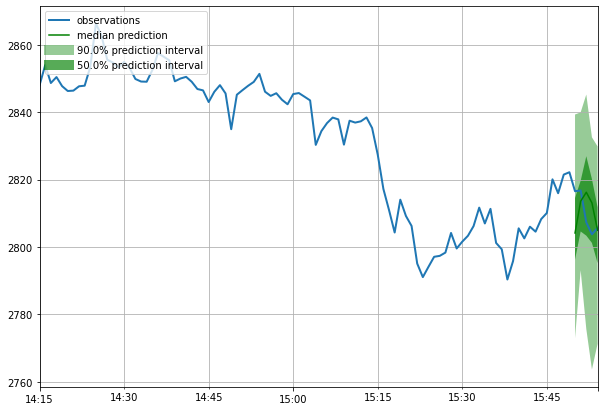

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  8.26it/s]


2021-12-02 08:44:44.750887 Aggregated performance
2021-12-02 08:44:44.751687 {
    "MSE": 109.34197998046875,
    "abs_error": 47.68212890625,
    "abs_target_sum": 12777.7099609375,
    "abs_target_mean": 2555.5419921875,
    "seasonal_error": 4.805460034229209,
    "MASE": 1.984497990477957,
    "MAPE": 0.003730771690607071,
    "sMAPE": 0.003739738464355469,
    "MSIS": 15.285631690677878,
    "QuantileLoss[0.1]": 28.906689453125,
    "Coverage[0.1]": 0.0,
    "RMSE": 10.456671553628752,
    "NRMSE": 0.004091762759365977,
    "ND": 0.003731664676379269,
    "wQuantileLoss[0.1]": 0.002262274659660855,
    "mean_absolute_QuantileLoss": 28.906689453125,
    "mean_wQuantileLoss": 0.002262274659660855,
    "MAE_Coverage": 0.1,
    "OWA": NaN
}


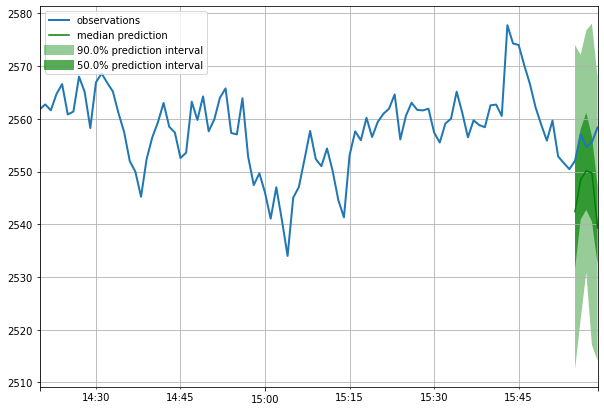

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  8.72it/s]


2021-12-02 08:44:45.779056 Aggregated performance
2021-12-02 08:44:45.779773 {
    "MSE": 905.1798828125,
    "abs_error": 139.617431640625,
    "abs_target_sum": 12434.2001953125,
    "abs_target_mean": 2486.8400390625,
    "seasonal_error": 4.898422148358265,
    "MASE": 5.700506302316905,
    "MAPE": 0.011247846484184264,
    "sMAPE": 0.011173678189516067,
    "MSIS": 16.101695199353063,
    "QuantileLoss[0.1]": 116.117431640625,
    "Coverage[0.1]": 0.8,
    "RMSE": 30.08620751793918,
    "NRMSE": 0.012098167572242085,
    "ND": 0.011228501186048026,
    "wQuantileLoss[0.1]": 0.009338552525831092,
    "mean_absolute_QuantileLoss": 116.117431640625,
    "mean_wQuantileLoss": 0.009338552525831092,
    "MAE_Coverage": 0.7000000000000001,
    "OWA": NaN
}


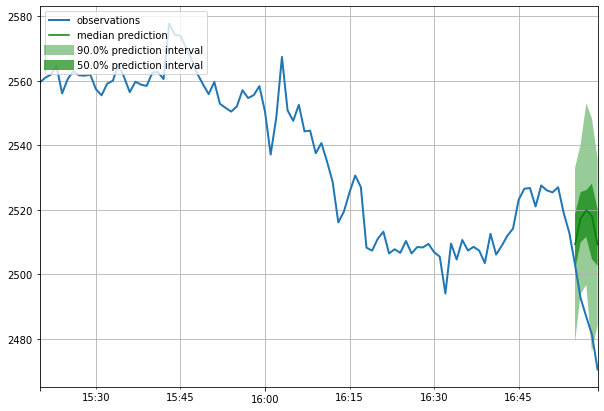

In [19]:
#
# Evaluate and visualize the prediction
#
import json

from gluonts.evaluation import Evaluator, MultivariateEvaluator

for test_dataset in test_datasets:
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_dataset,  # test dataset
        predictor=predictor,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )

    forecasts = list(forecast_it)
    forecast_entry = forecasts[0]
    tss = list(ts_it)

    # LOGGER.log(f"Number of sample paths: {forecast_entry.num_samples}")
    # LOGGER.log(f"Dimension of samples: {forecast_entry.samples.shape}")
    # LOGGER.log(f"Start date of the forecast window: {forecast_entry.start_date}")
    # LOGGER.log(f"Frequency of the time series: {forecast_entry.freq}")

    if ONE_DIM_TARGET:
        evaluator = Evaluator(quantiles=[0.1])
    else:
        evaluator = MultivariateEvaluator(quantiles=[0.1])

    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_dataset))

    for key in list(agg_metrics.keys()):
        if key[0].isdigit():
            del agg_metrics[key]
    LOGGER.log("Aggregated performance")
    LOGGER.log(json.dumps(agg_metrics, indent=4))

    if ONE_DIM_TARGET:
        plot_prob_forecasts(tss, forecasts)
    else:
        close_index = feature_columns.index("close")
        # close_index = feature_columns.index("log_return_close")
        LOGGER.log("'close' performance")
        LOGGER.log(item_metrics.iloc[close_index])

        plot_prob_forecasts_multi(tss, forecasts, close_index)

In [20]:
from mxnet.gluon import nn
import numpy as np

def count_model_params(net: nn.HybridBlock) -> int:
    params = net.collect_params()
    num_params = 0
    for p in params:
        v = params[p]
        num_params += np.prod(v.shape)
    return num_params

net_name = type(predictor.prediction_net).__name__
num_model_param = count_model_params(predictor.prediction_net)
print(f"Number of parameters in {net_name}: {num_model_param}")

def plot_prob_forecasts_multi2(ts_list, forecast_list, close_index, plot_length=60):
    for target, forecast in islice(zip(ts_list, forecast_list), len(forecast_list)):
        print(forecast)
        prediction_intervals = (50.0, 90.0)
        legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
        fig, ax = plt.subplots(1, 1, figsize=(10, 7))
        target[close_index][-plot_length:].plot(ax=ax)  # plot the time series
        forecast.copy_dim(close_index).plot(prediction_intervals=prediction_intervals, color='g')
        plt.grid(which="both")
        plt.legend(legend, loc="upper left")
        plt.show()

# close_index = feature_columns.index("close")
# LOGGER.log("'close' performance")
# LOGGER.log(item_metrics.iloc[close_index])
#
# plot_prob_forecasts_multi2(tss, forecasts, close_index)

Number of parameters in SimpleFeedForwardSamplingNetwork: 4089123


In [ ]:
#
# NOTE: FURTHER CELLS ARE COMPATIBLE WITH AWS SAGEMAKER ONLY, LOCAL MODE WILL NOT WORK
# Hyperparameter tune the model
#

from ml.tune import Tune

TUNE = Tune(UTILS, LOGGER)

train_dataset_uri = f"{dataset_dir_uri}/{config.TRAIN_DATASET_FILENAME}"
test_dataset_uri = f"{dataset_dir_uri}/{config.TEST_DATASET_FILENAME}"

# Note: Feel free to tune the tuner, i.e. update max number of jobs and hyperparameters. Default is 10 jobs, but you
# may want to change this as you refine the model. Additionally, if you find the best model has a parameter at the
# end of the range you gave it, then you should look to move that range to determine if the model performs better
# along that vector
tuner = TUNE.create_tuner(estimator)
TUNE.fit_tuner(tuner, dataset_dir_uri)

In [ ]:
#
# Get updates for Hyperparameter tune job. Ensure this is completed before going to the next cell
#

TUNE.get_tune_job_update()

In [ ]:
#
# Evaluate the metrics of the tune job
#

TUNE.report_job_analytics()
